# Train on Full Dataset

Now that we've created a dataset, let's try training on it.

In [1]:
from fastai.core import *
from fastai.vision import *
from fastai.vision.models import resnet18, resnet101

In [2]:
import torch
from torch import nn
from torch.nn import functional as F
"""
This file contains helper functions for building the model and for loading model parameters.
These helper functions are built to mirror those in the official TensorFlow implementation.
"""

import re
import math
import collections
from functools import partial
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils import model_zoo

########################################################################
############### HELPERS FUNCTIONS FOR MODEL ARCHITECTURE ###############
########################################################################


# Parameters for the entire model (stem, all blocks, and head)
GlobalParams = collections.namedtuple('GlobalParams', [
    'batch_norm_momentum', 'batch_norm_epsilon', 'dropout_rate',
    'num_classes', 'width_coefficient', 'depth_coefficient',
    'depth_divisor', 'min_depth', 'drop_connect_rate', 'image_size'])

# Parameters for an individual model block
BlockArgs = collections.namedtuple('BlockArgs', [
    'kernel_size', 'num_repeat', 'input_filters', 'output_filters',
    'expand_ratio', 'id_skip', 'stride', 'se_ratio'])

# Change namedtuple defaults
GlobalParams.__new__.__defaults__ = (None,) * len(GlobalParams._fields)
BlockArgs.__new__.__defaults__ = (None,) * len(BlockArgs._fields)


class SwishImplementation(torch.autograd.Function):
    @staticmethod
    def forward(ctx, i):
        result = i * torch.sigmoid(i)
        ctx.save_for_backward(i)
        return result

    @staticmethod
    def backward(ctx, grad_output):
        i = ctx.saved_variables[0]
        sigmoid_i = torch.sigmoid(i)
        return grad_output * (sigmoid_i * (1 + i * (1 - sigmoid_i)))


class MemoryEfficientSwish(nn.Module):
    def forward(self, x):
        return SwishImplementation.apply(x)

class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)


def round_filters(filters, global_params):
    """ Calculate and round number of filters based on depth multiplier. """
    multiplier = global_params.width_coefficient
    if not multiplier:
        return filters
    divisor = global_params.depth_divisor
    min_depth = global_params.min_depth
    filters *= multiplier
    min_depth = min_depth or divisor
    new_filters = max(min_depth, int(filters + divisor / 2) // divisor * divisor)
    if new_filters < 0.9 * filters:  # prevent rounding by more than 10%
        new_filters += divisor
    return int(new_filters)


def round_repeats(repeats, global_params):
    """ Round number of filters based on depth multiplier. """
    multiplier = global_params.depth_coefficient
    if not multiplier:
        return repeats
    return int(math.ceil(multiplier * repeats))


def drop_connect(inputs, p, training):
    """ Drop connect. """
    if not training: return inputs
    batch_size = inputs.shape[0]
    keep_prob = 1 - p
    random_tensor = keep_prob
    random_tensor += torch.rand([batch_size, 1, 1, 1], dtype=inputs.dtype, device=inputs.device)
    binary_tensor = torch.floor(random_tensor)
    output = inputs / keep_prob * binary_tensor
    return output


def get_same_padding_conv2d(image_size=None):
    """ Chooses static padding if you have specified an image size, and dynamic padding otherwise.
        Static padding is necessary for ONNX exporting of models. """
    if image_size is None:
        return Conv2dDynamicSamePadding
    else:
        return partial(Conv2dStaticSamePadding, image_size=image_size)


class Conv2dDynamicSamePadding(nn.Conv2d):
    """ 2D Convolutions like TensorFlow, for a dynamic image size """

    def __init__(self, in_channels, out_channels, kernel_size, stride=1, dilation=1, groups=1, bias=True):
        super().__init__(in_channels, out_channels, kernel_size, stride, 0, dilation, groups, bias)
        self.stride = self.stride if len(self.stride) == 2 else [self.stride[0]] * 2

    def forward(self, x):
        ih, iw = x.size()[-2:]
        kh, kw = self.weight.size()[-2:]
        sh, sw = self.stride
        oh, ow = math.ceil(ih / sh), math.ceil(iw / sw)
        pad_h = max((oh - 1) * self.stride[0] + (kh - 1) * self.dilation[0] + 1 - ih, 0)
        pad_w = max((ow - 1) * self.stride[1] + (kw - 1) * self.dilation[1] + 1 - iw, 0)
        if pad_h > 0 or pad_w > 0:
            x = F.pad(x, [pad_w // 2, pad_w - pad_w // 2, pad_h // 2, pad_h - pad_h // 2])
        return F.conv2d(x, self.weight, self.bias, self.stride, self.padding, self.dilation, self.groups)


class Conv2dStaticSamePadding(nn.Conv2d):
    """ 2D Convolutions like TensorFlow, for a fixed image size"""

    def __init__(self, in_channels, out_channels, kernel_size, image_size=None, **kwargs):
        super().__init__(in_channels, out_channels, kernel_size, **kwargs)
        self.stride = self.stride if len(self.stride) == 2 else [self.stride[0]] * 2

        # Calculate padding based on image size and save it
        assert image_size is not None
        ih, iw = image_size if type(image_size) == list else [image_size, image_size]
        kh, kw = self.weight.size()[-2:]
        sh, sw = self.stride
        oh, ow = math.ceil(ih / sh), math.ceil(iw / sw)
        pad_h = max((oh - 1) * self.stride[0] + (kh - 1) * self.dilation[0] + 1 - ih, 0)
        pad_w = max((ow - 1) * self.stride[1] + (kw - 1) * self.dilation[1] + 1 - iw, 0)
        if pad_h > 0 or pad_w > 0:
            self.static_padding = nn.ZeroPad2d((pad_w // 2, pad_w - pad_w // 2, pad_h // 2, pad_h - pad_h // 2))
        else:
            self.static_padding = Identity()

    def forward(self, x):
        x = self.static_padding(x)
        x = F.conv2d(x, self.weight, self.bias, self.stride, self.padding, self.dilation, self.groups)
        return x


class Identity(nn.Module):
    def __init__(self, ):
        super(Identity, self).__init__()

    def forward(self, input):
        return input


########################################################################
############## HELPERS FUNCTIONS FOR LOADING MODEL PARAMS ##############
########################################################################


def efficientnet_params(model_name):
    """ Map EfficientNet model name to parameter coefficients. """
    params_dict = {
        # Coefficients:   width,depth,res,dropout
        'efficientnet-b0': (1.0, 1.0, 224, 0.2),
        'efficientnet-b1': (1.0, 1.1, 240, 0.2),
        'efficientnet-b2': (1.1, 1.2, 260, 0.3),
        'efficientnet-b3': (1.2, 1.4, 300, 0.3),
        'efficientnet-b4': (1.4, 1.8, 380, 0.4),
        'efficientnet-b5': (1.6, 2.2, 456, 0.4),
        'efficientnet-b6': (1.8, 2.6, 528, 0.5),
        'efficientnet-b7': (2.0, 3.1, 600, 0.5),
        'efficientnet-b8': (2.2, 3.6, 672, 0.5),
        'efficientnet-l2': (4.3, 5.3, 800, 0.5),
    }
    return params_dict[model_name]


class BlockDecoder(object):
    """ Block Decoder for readability, straight from the official TensorFlow repository """

    @staticmethod
    def _decode_block_string(block_string):
        """ Gets a block through a string notation of arguments. """
        assert isinstance(block_string, str)

        ops = block_string.split('_')
        options = {}
        for op in ops:
            splits = re.split(r'(\d.*)', op)
            if len(splits) >= 2:
                key, value = splits[:2]
                options[key] = value

        # Check stride
        assert (('s' in options and len(options['s']) == 1) or
                (len(options['s']) == 2 and options['s'][0] == options['s'][1]))

        return BlockArgs(
            kernel_size=int(options['k']),
            num_repeat=int(options['r']),
            input_filters=int(options['i']),
            output_filters=int(options['o']),
            expand_ratio=int(options['e']),
            id_skip=('noskip' not in block_string),
            se_ratio=float(options['se']) if 'se' in options else None,
            stride=[int(options['s'][0])])

    @staticmethod
    def _encode_block_string(block):
        """Encodes a block to a string."""
        args = [
            'r%d' % block.num_repeat,
            'k%d' % block.kernel_size,
            's%d%d' % (block.strides[0], block.strides[1]),
            'e%s' % block.expand_ratio,
            'i%d' % block.input_filters,
            'o%d' % block.output_filters
        ]
        if 0 < block.se_ratio <= 1:
            args.append('se%s' % block.se_ratio)
        if block.id_skip is False:
            args.append('noskip')
        return '_'.join(args)

    @staticmethod
    def decode(string_list):
        """
        Decodes a list of string notations to specify blocks inside the network.

        :param string_list: a list of strings, each string is a notation of block
        :return: a list of BlockArgs namedtuples of block args
        """
        assert isinstance(string_list, list)
        blocks_args = []
        for block_string in string_list:
            blocks_args.append(BlockDecoder._decode_block_string(block_string))
        return blocks_args

    @staticmethod
    def encode(blocks_args):
        """
        Encodes a list of BlockArgs to a list of strings.

        :param blocks_args: a list of BlockArgs namedtuples of block args
        :return: a list of strings, each string is a notation of block
        """
        block_strings = []
        for block in blocks_args:
            block_strings.append(BlockDecoder._encode_block_string(block))
        return block_strings


def efficientnet(width_coefficient=None, depth_coefficient=None, dropout_rate=0.2,
                 drop_connect_rate=0.2, image_size=None, num_classes=1000):
    """ Creates a efficientnet model. """

    blocks_args = [
        'r1_k3_s11_e1_i32_o16_se0.25', 'r2_k3_s22_e6_i16_o24_se0.25',
        'r2_k5_s22_e6_i24_o40_se0.25', 'r3_k3_s22_e6_i40_o80_se0.25',
        'r3_k5_s11_e6_i80_o112_se0.25', 'r4_k5_s22_e6_i112_o192_se0.25',
        'r1_k3_s11_e6_i192_o320_se0.25',
    ]
    blocks_args = BlockDecoder.decode(blocks_args)

    global_params = GlobalParams(
        batch_norm_momentum=0.99,
        batch_norm_epsilon=1e-3,
        dropout_rate=dropout_rate,
        drop_connect_rate=drop_connect_rate,
        # data_format='channels_last',  # removed, this is always true in PyTorch
        num_classes=num_classes,
        width_coefficient=width_coefficient,
        depth_coefficient=depth_coefficient,
        depth_divisor=8,
        min_depth=None,
        image_size=image_size,
    )

    return blocks_args, global_params


def get_model_params(model_name, override_params):
    """ Get the block args and global params for a given model """
    if model_name.startswith('efficientnet'):
        w, d, s, p = efficientnet_params(model_name)
        # note: all models have drop connect rate = 0.2
        blocks_args, global_params = efficientnet(
            width_coefficient=w, depth_coefficient=d, dropout_rate=p, image_size=s)
    else:
        raise NotImplementedError('model name is not pre-defined: %s' % model_name)
    if override_params:
        # ValueError will be raised here if override_params has fields not included in global_params.
        global_params = global_params._replace(**override_params)
    return blocks_args, global_params


url_map = {
    'efficientnet-b0': 'https://publicmodels.blob.core.windows.net/container/aa/efficientnet-b0-355c32eb.pth',
    'efficientnet-b1': 'https://publicmodels.blob.core.windows.net/container/aa/efficientnet-b1-f1951068.pth',
    'efficientnet-b2': 'https://publicmodels.blob.core.windows.net/container/aa/efficientnet-b2-8bb594d6.pth',
    'efficientnet-b3': 'https://publicmodels.blob.core.windows.net/container/aa/efficientnet-b3-5fb5a3c3.pth',
    'efficientnet-b4': 'https://publicmodels.blob.core.windows.net/container/aa/efficientnet-b4-6ed6700e.pth',
    'efficientnet-b5': 'https://publicmodels.blob.core.windows.net/container/aa/efficientnet-b5-b6417697.pth',
    'efficientnet-b6': 'https://publicmodels.blob.core.windows.net/container/aa/efficientnet-b6-c76e70fd.pth',
    'efficientnet-b7': 'https://publicmodels.blob.core.windows.net/container/aa/efficientnet-b7-dcc49843.pth',
}


url_map_advprop = {
    'efficientnet-b0': 'https://publicmodels.blob.core.windows.net/container/advprop/efficientnet-b0-b64d5a18.pth', 
    'efficientnet-b1': 'https://publicmodels.blob.core.windows.net/container/advprop/efficientnet-b1-0f3ce85a.pth',
    'efficientnet-b2': 'https://publicmodels.blob.core.windows.net/container/advprop/efficientnet-b2-6e9d97e5.pth',
    'efficientnet-b3': 'https://publicmodels.blob.core.windows.net/container/advprop/efficientnet-b3-cdd7c0f4.pth',
    'efficientnet-b4': 'https://publicmodels.blob.core.windows.net/container/advprop/efficientnet-b4-44fb3a87.pth',
    'efficientnet-b5': 'https://publicmodels.blob.core.windows.net/container/advprop/efficientnet-b5-86493f6b.pth',
    'efficientnet-b6': 'https://publicmodels.blob.core.windows.net/container/advprop/efficientnet-b6-ac80338e.pth',
    'efficientnet-b7': 'https://publicmodels.blob.core.windows.net/container/advprop/efficientnet-b7-4652b6dd.pth',
    'efficientnet-b8': 'https://publicmodels.blob.core.windows.net/container/advprop/efficientnet-b8-22a8fe65.pth',
}


def load_pretrained_weights(model, model_name, load_fc=True, advprop=False):
    """ Loads pretrained weights, and downloads if loading for the first time. """
    # AutoAugment or Advprop (different preprocessing)
    url_map_ = url_map_advprop if advprop else url_map
    state_dict = model_zoo.load_url(url_map_[model_name])
    if load_fc:
        model.load_state_dict(state_dict)
    else:
        state_dict.pop('_fc.weight')
        state_dict.pop('_fc.bias')
        res = model.load_state_dict(state_dict, strict=False)
        assert set(res.missing_keys) == set(['_fc.weight', '_fc.bias']), 'issue loading pretrained weights'
    print('Loaded pretrained weights for {}'.format(model_name))
    
class MBConvBlock(nn.Module):
    """
    Mobile Inverted Residual Bottleneck Block

    Args:
        block_args (namedtuple): BlockArgs, see above
        global_params (namedtuple): GlobalParam, see above

    Attributes:
        has_se (bool): Whether the block contains a Squeeze and Excitation layer.
    """

    def __init__(self, block_args, global_params):
        super().__init__()
        self._block_args = block_args
        self._bn_mom = 1 - global_params.batch_norm_momentum
        self._bn_eps = global_params.batch_norm_epsilon
        self.has_se = (self._block_args.se_ratio is not None) and (0 < self._block_args.se_ratio <= 1)
        self.id_skip = block_args.id_skip  # skip connection and drop connect

        # Get static or dynamic convolution depending on image size
        Conv2d = get_same_padding_conv2d(image_size=global_params.image_size)

        # Expansion phase
        inp = self._block_args.input_filters  # number of input channels
        oup = self._block_args.input_filters * self._block_args.expand_ratio  # number of output channels
        if self._block_args.expand_ratio != 1:
            self._expand_conv = Conv2d(in_channels=inp, out_channels=oup, kernel_size=1, bias=False)
            self._bn0 = nn.BatchNorm2d(num_features=oup, momentum=self._bn_mom, eps=self._bn_eps)

        # Depthwise convolution phase
        k = self._block_args.kernel_size
        s = self._block_args.stride
        self._depthwise_conv = Conv2d(
            in_channels=oup, out_channels=oup, groups=oup,  # groups makes it depthwise
            kernel_size=k, stride=s, bias=False)
        self._bn1 = nn.BatchNorm2d(num_features=oup, momentum=self._bn_mom, eps=self._bn_eps)

        # Squeeze and Excitation layer, if desired
        if self.has_se:
            num_squeezed_channels = max(1, int(self._block_args.input_filters * self._block_args.se_ratio))
            self._se_reduce = Conv2d(in_channels=oup, out_channels=num_squeezed_channels, kernel_size=1)
            self._se_expand = Conv2d(in_channels=num_squeezed_channels, out_channels=oup, kernel_size=1)

        # Output phase
        final_oup = self._block_args.output_filters
        self._project_conv = Conv2d(in_channels=oup, out_channels=final_oup, kernel_size=1, bias=False)
        self._bn2 = nn.BatchNorm2d(num_features=final_oup, momentum=self._bn_mom, eps=self._bn_eps)
        self._swish = MemoryEfficientSwish()

    def forward(self, inputs, drop_connect_rate=None):
        """
        :param inputs: input tensor
        :param drop_connect_rate: drop connect rate (float, between 0 and 1)
        :return: output of block
        """

        # Expansion and Depthwise Convolution
        x = inputs
        if self._block_args.expand_ratio != 1:
            x = self._swish(self._bn0(self._expand_conv(inputs)))
        x = self._swish(self._bn1(self._depthwise_conv(x)))

        # Squeeze and Excitation
        if self.has_se:
            x_squeezed = F.adaptive_avg_pool2d(x, 1)
            x_squeezed = self._se_expand(self._swish(self._se_reduce(x_squeezed)))
            x = torch.sigmoid(x_squeezed) * x

        x = self._bn2(self._project_conv(x))

        # Skip connection and drop connect
        input_filters, output_filters = self._block_args.input_filters, self._block_args.output_filters
        if self.id_skip and self._block_args.stride == 1 and input_filters == output_filters:
            if drop_connect_rate:
                x = drop_connect(x, p=drop_connect_rate, training=self.training)
            x = x + inputs  # skip connection
        return x

    def set_swish(self, memory_efficient=True):
        """Sets swish function as memory efficient (for training) or standard (for export)"""
        self._swish = MemoryEfficientSwish() if memory_efficient else Swish()


class EfficientNet(nn.Module):
    """
    An EfficientNet model. Most easily loaded with the .from_name or .from_pretrained methods

    Args:
        blocks_args (list): A list of BlockArgs to construct blocks
        global_params (namedtuple): A set of GlobalParams shared between blocks

    Example:
        model = EfficientNet.from_pretrained('efficientnet-b0')

    """

    def __init__(self, blocks_args=None, global_params=None):
        super().__init__()
        assert isinstance(blocks_args, list), 'blocks_args should be a list'
        assert len(blocks_args) > 0, 'block args must be greater than 0'
        self._global_params = global_params
        self._blocks_args = blocks_args

        # Get static or dynamic convolution depending on image size
        Conv2d = get_same_padding_conv2d(image_size=global_params.image_size)

        # Batch norm parameters
        bn_mom = 1 - self._global_params.batch_norm_momentum
        bn_eps = self._global_params.batch_norm_epsilon

        # Stem
        in_channels = 3  # rgb
        out_channels = round_filters(32, self._global_params)  # number of output channels
        self._conv_stem = Conv2d(in_channels, out_channels, kernel_size=3, stride=2, bias=False)
        self._bn0 = nn.BatchNorm2d(num_features=out_channels, momentum=bn_mom, eps=bn_eps)

        # Build blocks
        self._blocks = nn.ModuleList([])
        for block_args in self._blocks_args:

            # Update block input and output filters based on depth multiplier.
            block_args = block_args._replace(
                input_filters=round_filters(block_args.input_filters, self._global_params),
                output_filters=round_filters(block_args.output_filters, self._global_params),
                num_repeat=round_repeats(block_args.num_repeat, self._global_params)
            )

            # The first block needs to take care of stride and filter size increase.
            self._blocks.append(MBConvBlock(block_args, self._global_params))
            if block_args.num_repeat > 1:
                block_args = block_args._replace(input_filters=block_args.output_filters, stride=1)
            for _ in range(block_args.num_repeat - 1):
                self._blocks.append(MBConvBlock(block_args, self._global_params))

        # Head
        in_channels = block_args.output_filters  # output of final block
        out_channels = round_filters(1280, self._global_params)
        self._conv_head = Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self._bn1 = nn.BatchNorm2d(num_features=out_channels, momentum=bn_mom, eps=bn_eps)

        # Final linear layer
        self._avg_pooling = nn.AdaptiveAvgPool2d(1)
        self._dropout = nn.Dropout(self._global_params.dropout_rate)
        self._fc = nn.Linear(out_channels, self._global_params.num_classes)
        self._swish = MemoryEfficientSwish()

    def set_swish(self, memory_efficient=True):
        """Sets swish function as memory efficient (for training) or standard (for export)"""
        self._swish = MemoryEfficientSwish() if memory_efficient else Swish()
        for block in self._blocks:
            block.set_swish(memory_efficient)


    def extract_features(self, inputs):
        """ Returns output of the final convolution layer """

        # Stem
        x = self._swish(self._bn0(self._conv_stem(inputs)))

        # Blocks
        for idx, block in enumerate(self._blocks):
            drop_connect_rate = self._global_params.drop_connect_rate
            if drop_connect_rate:
                drop_connect_rate *= float(idx) / len(self._blocks)
            x = block(x, drop_connect_rate=drop_connect_rate)

        # Head
        x = self._swish(self._bn1(self._conv_head(x)))

        return x

    def forward(self, inputs):
        """ Calls extract_features to extract features, applies final linear layer, and returns logits. """
        bs = inputs.size(0)
        # Convolution layers
        x = self.extract_features(inputs)

        # Pooling and final linear layer
        x = self._avg_pooling(x)
        x = x.view(bs, -1)
        x = self._dropout(x)
        x = self._fc(x)
        return x

    @classmethod
    def from_name(cls, model_name, override_params=None):
        cls._check_model_name_is_valid(model_name)
        blocks_args, global_params = get_model_params(model_name, override_params)
        return cls(blocks_args, global_params)

    @classmethod
    def from_pretrained(cls, model_name, advprop=False, num_classes=1000, in_channels=3):
        model = cls.from_name(model_name, override_params={'num_classes': num_classes})
        load_pretrained_weights(model, model_name, load_fc=(num_classes == 1000), advprop=advprop)
        if in_channels != 3:
            Conv2d = get_same_padding_conv2d(image_size = model._global_params.image_size)
            out_channels = round_filters(32, model._global_params)
            model._conv_stem = Conv2d(in_channels, out_channels, kernel_size=3, stride=2, bias=False)
        return model
    
    @classmethod
    def get_image_size(cls, model_name):
        cls._check_model_name_is_valid(model_name)
        _, _, res, _ = efficientnet_params(model_name)
        return res

    @classmethod
    def _check_model_name_is_valid(cls, model_name):
        """ Validates model name. """ 
        valid_models = ['efficientnet-b'+str(i) for i in range(9)]
        if model_name not in valid_models:
            raise ValueError('model_name should be one of: ' + ', '.join(valid_models))

In [3]:
path = Path('../data/cropped_faces')

In [4]:
src = ImageList.from_folder(path).split_by_folder(train='train', valid='valid')

In [5]:
def get_data(bs,size):
    data = (src.label_from_re('([A-Z]+).jpg$')
           .transform(get_transforms(max_warp=0, max_zoom=1), size=size, resize_method=ResizeMethod.PAD, padding_mode="zeros")
           .databunch(bs=bs).normalize(imagenet_stats))
    return data

In [6]:
bs, sz = 32, 256
data = get_data(bs, sz)

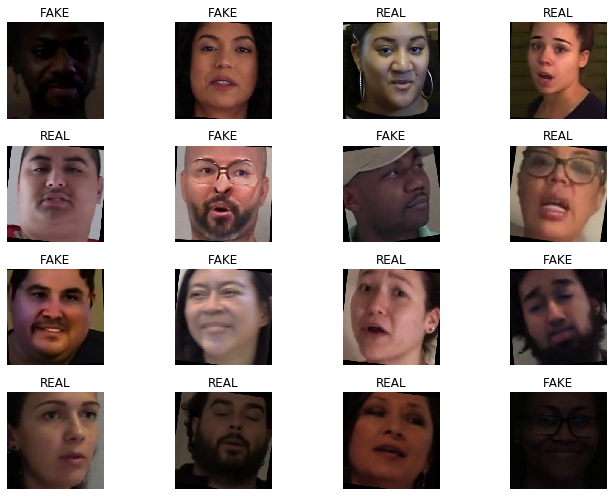

In [7]:
data.show_batch(rows=4, figsize=(10,7))

In [8]:
model = EfficientNet.from_pretrained('efficientnet-b1', num_classes=data.c)
learner = Learner(data, model, metrics=[accuracy])

Loaded pretrained weights for efficientnet-b1


In [9]:
learner.fit_one_cycle(10, 1e-3)

epoch,train_loss,valid_loss,accuracy,time


RuntimeError: CUDA out of memory. Tried to allocate 30.00 MiB (GPU 0; 11.91 GiB total capacity; 3.23 GiB already allocated; 37.25 MiB free; 3.29 GiB reserved in total by PyTorch)

In [ ]:
learner.recorder.plot_losses()

In [ ]:
torch.save(learner.model.state_dict, 'single_epoch.pth')